# Detecting Spam SMS Messages with the Naive Bayes Algorithm

In this guided project, we're going to use the Naive Bayes algorithm to build a spam filter for SMS messages. To classify messages as spam or non-spam, the computer:
* Learns how humans classify messages
* Uses that human knowledge to estimate probabilities for new messages — probabilities for spam and non-spam
* Classifies a new message based on these probability values — if the probability for spam is greater, then it classifies the message as spam. Otherwise, it classifies it as non-spam (if the two probability values are equal, then we may need a human to classify the message)

The dataset we'll use to both train and test the algorithm consists of 5,572 SMS messages that are already classified by humans. The dataset was put together by Tiago A. Almeida and José María Gómez Hidalgo, and it can be downloaded directly from this link: [here](https://dq-content.s3.amazonaws.com/433/SMSSpamCollection). Additional information on the dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection)

In [1]:
import pandas as pd
import re
import warnings
warnings.filterwarnings('ignore')

## Data Exploration

In [2]:
spam = pd.read_csv('SMSSpamCollection', sep='\t', header=None, names=['Label','SMS'])
spam.head()

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
# check percentage of spam/not spam texts
spam['Label'].value_counts(normalize=True)

ham     0.865937
spam    0.134063
Name: Label, dtype: float64

Our dataset is fairly simple. There's two columns, one that indicates whether the message is spam or not (*ham = not spam*) and the other column has the actual text message. 87% of messages in our dataset are not spam and 13% are spam.

## Defining Our Goal
Our goal is for the spam filter to classify new messages with an accuracy greater than 80%. Before creating the spam filter, we want to define how we'll test the accuracy. In order to do this, we'll need to split the data into training and test data. The training data will be used to teach the computer how to classify messages, and the test data we'll be used to test our filter once it's complete.
* The training set will have 4,458 messages (about 80% of the dataset)
* The test set will have 1,114 messages (about 20% of the dataset)  

It's important we have 'new' data that the filter hasn't seen before to have a fair test. All of our data has already been classified by a human so we'll be able to compare the results of our filter to how the texts were classified by a human for testing.

### Splitting the Data
We'll randomize the data, then we'll split it into Training and Test data as specified above.

In [4]:
# randomize data
randomized = spam.sample(frac=1, random_state=1)
# split data
training_set = randomized[:4458]
test_set = randomized[4458:]
# reset index on new dataframes
training_set.reset_index(drop=True, inplace=True)
test_set.reset_index(drop=True, inplace=True)

Below we confirm that the percentages of spam and non-spam texts in our Traning and Test datasets are similar to our original dataset.

In [5]:
# checking percentage of ham / spam texts in new datasets
print(training_set['Label'].value_counts(normalize=True))
print(test_set['Label'].value_counts(normalize=True))

ham     0.86541
spam    0.13459
Name: Label, dtype: float64
ham     0.868043
spam    0.131957
Name: Label, dtype: float64


## Transforming Training Dataset
In order to calculate the probabilities for the Naive Bayes algorithm, we want to change the structure of our data that willl alow us to more easily extract the information we need. This is what the data transformation will look like:
* All words in the vocabulary (unique words from all text messages in our dataset) will be converted to lowercase for matching purposes
* Punctuation will be removed from the messages
* Replace the SMS column by a series of new columns, where each column represents a unique word from the vocabulary
* Each row will describe a single text message. It will indicate whether the text was spam or not and it will have a number in each of the unique word columns representing how many times that word appears in the text string.

In [6]:
# remove punctuation from text messages, convert to lower case, split string into list of words
training_set['SMS'] = training_set['SMS'].str.replace('\W', ' ').str.lower().str.split()

In [7]:
# create list of all words from text messages
vocabulary = []
for sms in training_set['SMS']:
    for word in sms:
        vocabulary.append(word)
# convert vocabulary list to set to remove duplicates        
vset = set(vocabulary)
# convert set back to list
vocabulary = list(vset)

Now that we have a list of all the unique words we want to create our new DataFrame. First, we'll create a dictionary where each key is a unique word (a string) from the vocabulary, and each value is a list of the length of the training set, where each element in the list is a 0. Then, we'll loop over <code>training_set['SMS']</code> to get the index and SMS message. Finally, we increment <code>word_counts_per_sms[word][index]</code> by 1 for all words in every SMS message.

In [8]:
# create dictionary
word_counts_per_sms = {unique_word: [0] * len(training_set['SMS']) for unique_word in vocabulary}
# count number of each word in SMS messages
for index, sms in enumerate(training_set['SMS']):
    for word in sms:
        word_counts_per_sms[word][index] += 1

In [9]:
word_counts_per_sms = pd.DataFrame(word_counts_per_sms)
word_counts_per_sms.head()

,cantdo,nichols,own,categories,shd,2price,concentration,bx,alert,sufficient,...,offering,psychiatrist,missin,wait,7am,mag,zaher,sway,68866,hallaq
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Above we can see the dictionary we created, converted into a DataFrame. Now, we just need to combine that with the original <code>training_set</code> DataFrame so we have the spam/ham label and the original string (which has been converted to a list). 

In [10]:
training_set_clean = pd.concat([training_set, word_counts_per_sms], axis=1)
training_set_clean.head()

,Label,SMS,cantdo,nichols,own,categories,shd,2price,concentration,bx,...,offering,psychiatrist,missin,wait,7am,mag,zaher,sway,68866,hallaq
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Creating the Spam Filter
Now that our data is clean, we can begin creating the spam filter. As mentioned previously, we will use the Naive Bayes algorithm to classify messages as spam or not. Additional information on the Naive Bayes algorithm can be found [here](https://www.kdnuggets.com/2020/06/naive-bayes-algorithm-everything.html).

In order to classify new messages, the Naive Bayes algorithm will need to know the probability values of these two equations: 
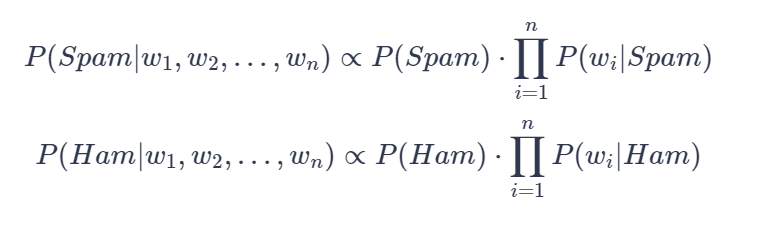  
Also, to calculate P(w<sub>i</sub>|Spam) and P(w<sub>i</sub>|Ham) inside the formulas above, recall that we need to use these equations:  
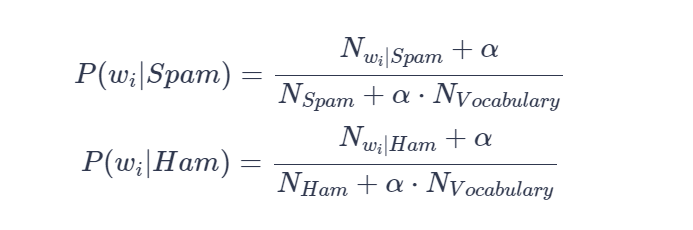  

## Constant Values
Some terms from the above equations will have constant values for every new message. We'll start by calculating these constant values so we won't have to do repeat calculations every time a new message comes in.

In [11]:
# isolate spam and non-spam messages
spam_messages = training_set_clean[training_set_clean['Label'] == 'spam']
ham_messages = training_set_clean[training_set_clean['Label'] == 'ham']

# P(Spam) and P(Ham)
p_spam = len(spam_messages) / len(training_set_clean)
p_ham = len(ham_messages) / len(training_set_clean)

# N_Spam
n_spam = spam_messages['SMS'].apply(len).sum()

#N_Ham
n_ham = ham_messages['SMS'].apply(len).sum()

#N_Vocabulary
n_vocabulary = len(vocabulary)

# Laplace smoothing
alpha = 1

## Calculating Parameters
We've calculated terms from the above equations that will have constant values for every new message (regardless of the message or each individual word in the message). Now, we'll calculate the other terms from the equation: P(w<sub>i</sub>|Spam) and P(w<sub>i</sub>|Ham). These values will vary depending on the individual words. For instance, P("secret"|Spam) will have a certain probability value, while P("cousin"|Spam) will most likely have a different probability value.  

Although both P(w<sub>i</sub>|Spam) and P(w<sub>i</sub>|Ham) vary depending on the word, the probability for each individual word is constant for every new message. We'll use the training set to calculate P(w<sub>i</sub>|Spam) and P(w<sub>i</sub>|Ham) for each individual word in each message and the steps we take to calculate those words we'll be the same. The key detail here is that calculating P(w<sub>i</sub>|Spam) and P(w<sub>i</sub>|Ham) only depends on the training set, and as long as we don't make changes to the training set, they will remain constant.

To calculate probability values for P(w<sub>i</sub>|Spam) and P(w<sub>i</sub>|Ham), we'll first create two dictionaries where each key is a unique word from our vocabulary and the value is 0. Then, we'll calculate the values for P(w<sub>i</sub>|Spam) and P(w<sub>i</sub>|Ham) and add them to the dictionaries we just created.

In [12]:
# create two dictionaries to store parameters 
spam_dict = {}
ham_dict = {}
for word in vocabulary:
    spam_dict[word] = 0
    ham_dict[word] = 0
    
# calculate parameters and add them to dictionaries    
for word in vocabulary:
    n_word_given_spam = spam_messages[word].sum()   # spam_messages already defined in a cell above
    p_word_given_spam = (n_word_given_spam + alpha) / (n_spam + alpha*n_vocabulary)
    spam_dict[word] += p_word_given_spam

    n_word_given_ham = ham_messages[word].sum()   # ham_messages already defined in a cell above
    p_word_given_ham = (n_word_given_ham + alpha) / (n_ham + alpha*n_vocabulary)
    ham_dict[word] += p_word_given_ham

## Classifying a Message as Spam
Now that we've calculated all the constants and parameters we need, we can start creating the spam filter. The spam filter can be understood as a function that:
* Takes in a new message as input
* Calculates P(w<sub>1</sub>,w<sub>2</sub>,...w<sub>n</sub>|Spam) and P(w<sub>1</sub>,w<sub>2</sub>,...w<sub>n</sub>|Ham)
* Compares the values of P(w<sub>1</sub>,w<sub>2</sub>,...w<sub>n</sub>|Spam) and P(w<sub>1</sub>,w<sub>2</sub>,...w<sub>n</sub>|Ham): 
  - If P(w<sub>1</sub>,w<sub>2</sub>,...w<sub>n</sub>|Ham) > P(w<sub>1</sub>,w<sub>2</sub>,...w<sub>n</sub>|Spam), then the message is classified as ham.
  - If P(w<sub>1</sub>,w<sub>2</sub>,...w<sub>n</sub>|Ham) < P(w<sub>1</sub>,w<sub>2</sub>,...w<sub>n</sub>|Spam), then the message is classified as spam.
  - If P(w<sub>1</sub>,w<sub>2</sub>,...w<sub>n</sub>|Ham) = P(w<sub>1</sub>,w<sub>2</sub>,...w<sub>n</sub>|Spam), then the algorithm may request human help.

In [13]:
# function that will classify as message as spam or ham
def classify(message):

    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()

    p_spam_given_message = p_spam
    p_ham_given_message = p_ham
    
    for word in message:
        if word in spam_dict:
            p_spam_given_message *= spam_dict[word]
        if word in ham_dict:
            p_ham_given_message *= ham_dict[word]

    print('P(Spam|message):', p_spam_given_message)
    print('P(Ham|message):', p_ham_given_message)

    if p_ham_given_message > p_spam_given_message:
        print('Label: Ham')
    elif p_ham_given_message < p_spam_given_message:
        print('Label: Spam')
    else:
        print('Equal proabilities, have a human classify this!')

In [14]:
# testing function
classify('WINNER!! This is the secret code to unlock the money: C3421.')

P(Spam|message): 1.3481290211300841e-25
P(Ham|message): 1.9368049028589875e-27
Label: Spam


In [15]:
# testing function
classify("Sounds good, Tom, then see u there")

P(Spam|message): 2.4372375665888117e-25
P(Ham|message): 3.687530435009238e-21
Label: Ham


## Testing Accuracy of Spam Filter
The spam filter seems to be working but now we can apply it to our test dataset to really determine the accuracy.

In [16]:
# replicating function above but just returning the label
def classify_test_set(message):

    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()

    p_spam_given_message = p_spam
    p_ham_given_message = p_ham
    
    for word in message:
        if word in spam_dict:
            p_spam_given_message *= spam_dict[word]
        if word in ham_dict:
            p_ham_given_message *= ham_dict[word]

    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_ham_given_message < p_spam_given_message:
        return 'spam'
    else:
        return 'Equal proabilities, have a human classify this!'

In [17]:
# applying above function to our test dataset, results stored in new column
test_set['algo_prediction'] = test_set['SMS'].apply(classify_test_set)

We can compare the results from our spam filter to the human categorization by comparing the column we just created to the human label.

In [18]:
# determine the percentage of text messages classified correctly by our spam filter
correct = 0
total = len(test_set)

for row in test_set.iterrows():
    algo = row[1]['algo_prediction']
    human = row[1]['Label']
    
    if algo == human:
        correct += 1
        
print('Percent Correct: ' + str(round((correct/total) * 100,2)))

Percent Correct: 98.74


We reached our goal of creating a SMS spam filter with over 80% accuracy. Our spam filter classified 98.74% text messages with the correct label.

# Conclusion
In this project we created a filter to classify SMS messages as spam or not spam using the Naive Bayes Algorithm. Our filter has been tested and we are confident in the results with 98.74% accuracy. Moving forward, we can take a look at the messages that were misclassified to see how we can improve our filter.